In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Mon Jul 29 19:09:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   45C    P0    57W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [3]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_split.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)

# Assuming 'split' column contains strings 'train', 'validation', 'test'
# Filter the loaded dataset into subsets
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')

Using custom data configuration default-31dfe7adddcf5ced
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 191.12it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ad71be204b279b28.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e7b6b615907c24ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-bee802838a3bfaea.arrow


In [4]:
train_dataset

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
    num_rows: 1623
})

In [5]:
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

In [6]:
columns_to_keep = ['claim', 'premise', 'label','category','count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat','counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
all_columns = train_dataset.column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2b0030fb2dfa4c5c.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2af2b7abf1a08f75.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-31dfe7adddcf5ced/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0bbf36fdf8be1d2b.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [8]:
len(dataset['val']['claim'])

465

In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='pritamdeka/PubMedBERT-MNLI-MedNLI'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts

        claim = item['claim']
        premise = item['premise'].replace('\n', '').replace('[','').replace(']','')
        
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        
        additional_features_ev = [
            'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
    
        for feature_ev in additional_features_ev:
            if feature_ev in item:
                premise += "[SEP]" + str(item[feature])
        item['claim']=claim
        item['premise']=premise        
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item




In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model = model.to(device)

In [13]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [15]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [16]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [17]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [18]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [19]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [20]:
tdata.__getitem__(0)

{'input_ids': tensor([    2,    31,  2067, 29949,  2126,   240,    16,    56,    18,    31,
          3363,  7369,  1019,   240,    16,    51,    18,    31,  7626,  5025,
           240,  6235,  2165,  1019,   240,    16,    58,    18,    31,  4357,
         23663,  1970, 25210,  1019,   240,    16,    55,    18,    31, 17725,
          1037, 12518,  2165,  1019,   240,    16,    57,    18,    31, 28193,
          8323, 12518,  2165,  1019,   240,    16,    52,    18, 14542,  4006,
          4480,  1930, 14227,  5004,  4415, 16984,  1930, 10659,  2043,  4480,
         13203,  1021,  3316,  2703,    17, 22248,  1927, 27041, 11638,  1036,
            18,  8236,  5182,  1035,    16,    51,    18, 22719,    10,  4272,
          9322,  1927, 26503,  4340,  7369,    12,    18,  5163,  3071,  1930,
          6595,  4575, 18068,  1030,  2564,  1927,  2949,  1930,  2310, 11963,
          1943,  1956, 14227,  5004,    12,  2689,  6285,  8846,  2629, 12492,
          1024,    13, 19490,    18,  4

In [21]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

device = torch.device("cuda:0")

training_args = TrainingArguments(
    output_dir=f'/home/elson/1.2.5_pubmedbert/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.1,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to("cuda:0"),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)
print(f"Model is on device: {next(model.parameters()).device}")
# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/1.2.5_pubmedbert/best_model')
tokenizer.save_pretrained(f'/home/elson/1.2.5_pubmedbert/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Model is on device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.823700,0.846590,0.612903,0.453245,0.619803,0.612903,0.609049
2,0.612300,0.846452,0.612903,0.488761,0.650303,0.612903,0.628516
3,0.362800,1.220849,0.632258,0.477926,0.638194,0.632258,0.635046
4,0.142600,1.710548,0.610753,0.519100,0.661441,0.610753,0.630772
5,0.163800,1.483083,0.640860,0.512112,0.662129,0.640860,0.638163
6,0.105300,2.191268,0.584946,0.527446,0.673452,0.584946,0.612834
7,0.062700,2.057341,0.638710,0.514251,0.659583,0.638710,0.647831
8,0.002100,2.467473,0.627957,0.537608,0.672148,0.627957,0.641254
9,0.016200,2.588481,0.636559,0.522894,0.664971,0.636559,0.645264
10,0.057300,2.410230,0.653763,0.544110,0.674867,0.653763,0.662014


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.2.5_pubmedbert/checkpoint-51
Configuration saved in /home/elson/1.2.5_pubmedbert/checkpoint-51/config.json
Model weights saved in /home/elson/1.2.5_pubmedbert/checkpoint-51/pytorch_model.bin
Deleting older checkpoint [/home/elson/1.2.5_pubmedbert/checkpoint-510] due to args.save_total_limit
Deleting older checkpoint [/home/elson/1.2.5_pubmedbert/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.2.5_pubmedbert/checkpoint-102
Configuration saved in /home/elson/1.2.5_pubmedbert/checkpoint-102/config.json
Model weights saved in /home/elson/1.2.5_pubmedbert/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.2.5_pubmedbert/checkpoint-153
Configuration saved in /home/elson/1.2.5_pubmedber

Configuration saved in /home/elson/1.2.5_pubmedbert/best_model/config.json
Model weights saved in /home/elson/1.2.5_pubmedbert/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/1.2.5_pubmedbert/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/1.2.5_pubmedbert/best_model/special_tokens_map.json


('/home/elson/1.2.5_pubmedbert/best_model/tokenizer_config.json',
 '/home/elson/1.2.5_pubmedbert/best_model/special_tokens_map.json',
 '/home/elson/1.2.5_pubmedbert/best_model/vocab.txt',
 '/home/elson/1.2.5_pubmedbert/best_model/added_tokens.json',
 '/home/elson/1.2.5_pubmedbert/best_model/tokenizer.json')

In [22]:
model_path = "/home/elson/1.2.5_pubmedbert/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/1.2.5_pubmedbert/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/1.2.5_pubmedbert/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading w

In [23]:
print(test_results)

PredictionOutput(predictions=array([[ 5.0234e+00, -3.0547e+00, -9.8877e-01],
       [-4.6289e+00,  5.8828e+00, -2.7285e+00],
       [-4.6836e+00,  5.3633e+00, -2.2734e+00],
       [-2.9590e+00,  5.3750e+00, -3.6914e+00],
       [-4.9336e+00,  5.6133e+00, -2.2402e+00],
       [-4.2461e+00,  6.0078e+00, -3.0352e+00],
       [-4.5898e+00,  6.1016e+00, -2.7676e+00],
       [-5.5898e+00,  5.3281e+00, -1.2090e+00],
       [-4.5938e+00,  6.0625e+00, -2.7168e+00],
       [-4.1602e+00,  6.0078e+00, -3.1094e+00],
       [-3.2500e+00,  5.9922e+00, -3.7168e+00],
       [-4.0898e+00,  6.0625e+00, -3.0586e+00],
       [-4.4688e+00,  5.8438e+00, -2.7227e+00],
       [-5.3008e+00,  5.6445e+00, -1.9033e+00],
       [-5.0508e+00,  5.6641e+00, -2.0996e+00],
       [ 6.2070e+00, -1.5967e+00, -3.8887e+00],
       [-4.3516e+00,  6.1055e+00, -3.0664e+00],
       [-4.6172e+00,  4.5820e+00, -1.3516e+00],
       [-4.4180e+00,  6.0117e+00, -2.8340e+00],
       [-4.5586e+00,  6.0156e+00, -2.8320e+00],
       [-4.

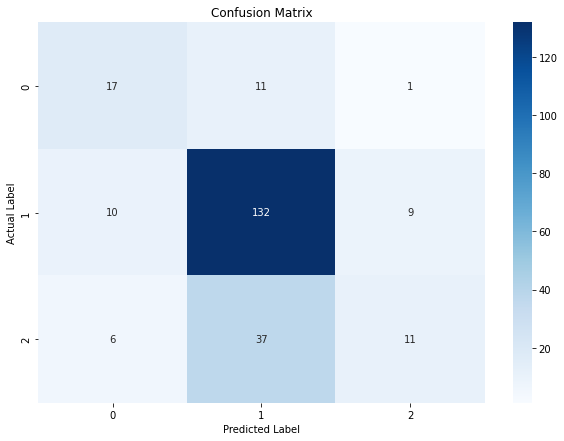

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [25]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/1.2.5_results.csv', index=False)

In [26]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [27]:
correct_classification_counts

General Health           33
Bone health              15
Fitness                  14
Cancer                   12
Skin                     12
Cardiovascular Health    11
Diabetes                  9
Neurological health       9
Throat                    9
Eye                       8
Ear                       6
Hair                      6
Women' s Health           4
Blood                     4
Men's health              3
Mental Health             2
Muscles                   1
Vascular                  1
Dental Health             1
Name: Category, dtype: int64

In [28]:
misclassification_counts

General Health           18
Skin                     12
Bone health               6
Hair                      6
COVID                     6
Muscles                   5
Blood                     5
Diabetes                  3
Men's health              3
Vascular                  2
Women' s Health           2
Dental Health             2
Eye                       1
Cardiovascular Health     1
Fitness                   1
Mental Health             1
Name: Category, dtype: int64